In [221]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# standard libraries
import os
import numpy as np
import pandas as pd
from datetime import datetime

# modeling libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

# viz libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
plt.style.use("fivethirtyeight")

### Project Overview

For this project I will build an LSTM network to predict future transactions for a single retailer. The relevant data contains transaction history for a single retailer from 2009-2011. I will briefly highlight what each field in the dataset represents. This notebook will contain exploratory analysis, proper reformatting of time series data, LSTM model training and experimenting, and finally comparing model predictions against the holdout test dataset.

The data for this project is provided by Kaggle and can be found [here](https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository).

Brief description of column fields and what they represent:

- **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice date and time. Numeric. The day and time when a transaction was generated.
- **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
- **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal. The name of the country where a customer resides.

### EDA

In [16]:
# start by downloading dataset using Kaggle API then reading in
!kaggle datasets download -d mathchi/online-retail-ii-data-set-from-ml-repository

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 181, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [28]:
df1 = pd.read_csv("/kaggle/input/online-retail-ii-data-set-from-ml-repository/Year 2009-2010.csv", encoding= 'unicode_escape')
df2 = pd.read_csv("/kaggle/input/online-retail-ii-data-set-from-ml-repository/Year 2010-2011.csv", encoding= 'unicode_escape')

df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

df1["data_year"] = "2009-2010"
df2["data_year"] = "2010-2011"

print(f"min date in 2009 dataset: {min(df1.InvoiceDate)}")
print(f"max date in 2009 dataset: {max(df1.InvoiceDate)}")

print(f"min date in 2010 dataset: {min(df2.InvoiceDate)}")
print(f"max date in 2010 dataset: {max(df2.InvoiceDate)}")

min date in 2009 dataset: 2009-12-01 07:45:00
max date in 2009 dataset: 2010-12-09 20:01:00
min date in 2010 dataset: 2010-12-01 08:26:00
max date in 2010 dataset: 2011-12-09 12:50:00


In [30]:
# concatenating together, will work from this concatenated dataframe
df = pd.concat([df1, df2])

print(df.info(memory_usage=True, show_counts=True))
df.sample(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   data_year    1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 81.4+ MB
None


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,data_year
471768,533822,22232,JIGSAW TOADSTOOLS 3 PIECE,8,2010-11-19 09:40:00,1.65,12647.0,Germany,2009-2010
253468,513799,22423,REGENCY CAKESTAND 3 TIER,2,2010-06-28 16:42:00,12.75,14182.0,United Kingdom,2009-2010
311699,564314,21650,ASSORTED TUTTI FRUTTI BRACELET,24,2011-08-24 12:58:00,0.19,12695.0,France,2010-2011
44529,493283,85127,SMALL SQUARE CUT GLASS CANDLESTICK,4,2009-12-22 15:12:00,10.39,NaN,United Kingdom,2009-2010


In [34]:
# to simplify the analysis and EDA, will convert the Invoicedate field from timestamps to days.
# that way we can aggregate on the day field, which is going to be the primary focus of this analysis
df['InvoiceDay'] = df.InvoiceDate.dt.date

In [52]:
# units sold and revenue over time
df_grouped1 = df.groupby(["InvoiceDay"]).agg({"Price": "sum", "Quantity": "sum"}).reset_index()
df_grouped1 = df_grouped1.sort_values("InvoiceDay").reset_index(drop=True)

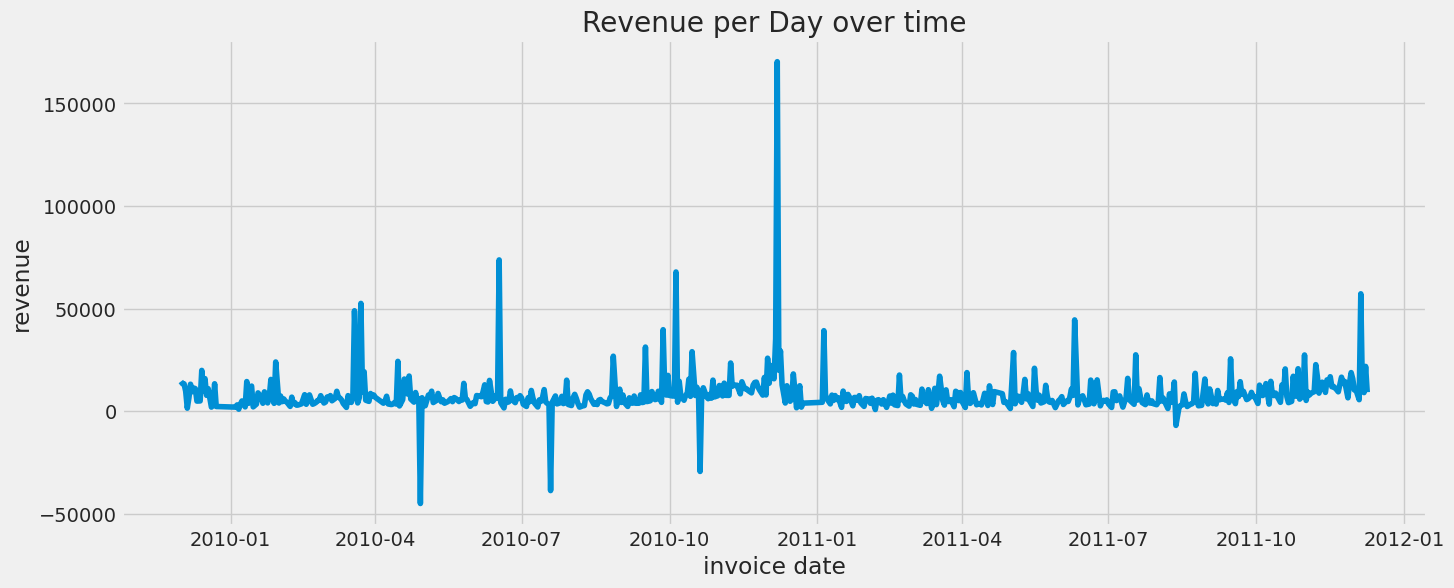

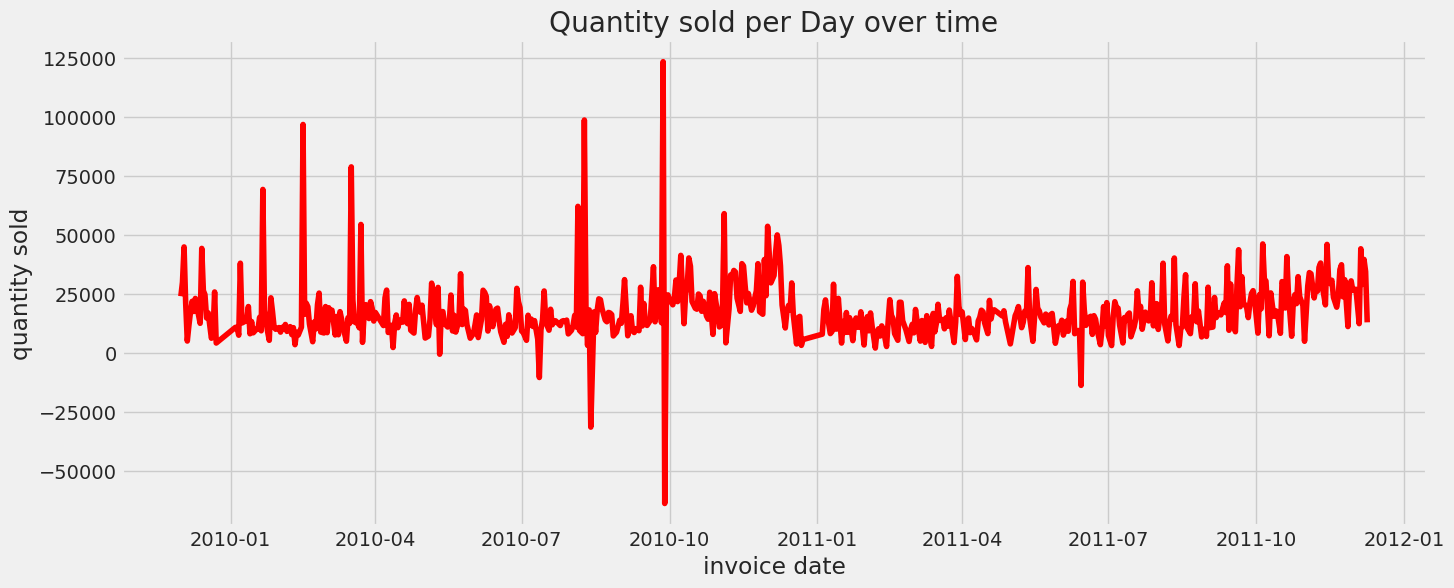

In [62]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df_grouped1["InvoiceDay"], y=df_grouped1["Price"])
plt.title("Revenue per Day over time")
plt.xlabel("invoice date")
plt.ylabel("revenue")
plt.show()

plt.figure(figsize=(15,6))
sns.lineplot(x=df_grouped1["InvoiceDay"], y=df_grouped1["Quantity"], color="r")
plt.title("Quantity sold per Day over time")
plt.xlabel("invoice date")
plt.ylabel("quantity sold")
plt.show()

In [79]:
# we can also notice that there is a single outlier in price field where price exceeds 150k
# will also fill this in with rolling window avg to not skew model data
df_grouped1.loc[df_grouped1.Price > 150_000, "Price"] = np.nan
df_grouped1.Price = df_grouped1.Price.fillna(df_grouped1.Price.rolling(30).mean().shift())

df_grouped1.loc[df_grouped1.Quantity > 100_000, "Quantity"] = np.nan
df_grouped1.Quantity = df_grouped1.Quantity.fillna(df_grouped1.Quantity.rolling(30).mean().shift())

#### Moving Average of price and revenue

In [70]:
# calculating moving avg for both columns over various rolling windows
windows = [7, 30, 60]
cols = ["Price", "Quantity"]

for window in windows:
    for col in cols:
        col_name = f"{window}day_moving_avg_{col}"
        df_grouped1[col_name] = df_grouped1[col].rolling(window).mean()

In [74]:
df_grouped1

,InvoiceDay,Price,Quantity,7day_moving_avg_Price,7day_moving_avg_Quantity,30day_moving_avg_Price,30day_moving_avg_Quantity,60day_moving_avg_Price,60day_moving_avg_Quantity
0,2009-12-01,14450.54,24022.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-12-02,13411.96,29942.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-12-03,13290.25,44896.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-12-04,9687.28,21001.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-12-05,1443.26,5033.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
599,2011-12-05,57195.74,44119.0,18842.492857,27989.428571,13687.236667,28352.400000,11737.581333,25261.583333
600,2011-12-06,10364.64,29026.0,18340.940000,28043.571429,13858.706667,28763.733333,11796.596333,25394.350000
601,2011-12-07,9049.19,39612.0,16948.301429,29343.714286,13849.731667,29140.166667,11794.737833,25635.266667
602,2011-12-08,21808.10,34460.0,17812.740000,30483.428571,14315.411000,29154.866667,12038.403667,25770.183333


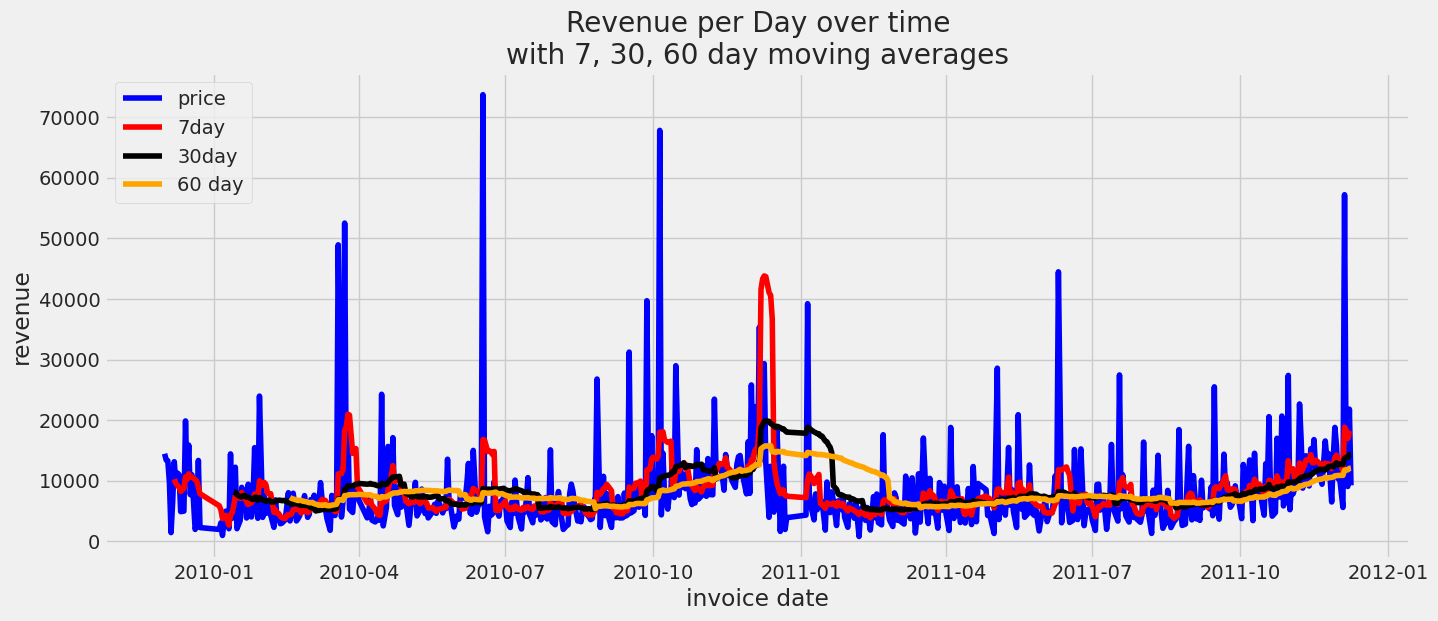

In [85]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="Price", color="blue", label="price")
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="7day_moving_avg_Price", color="red", label="7day")
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="30day_moving_avg_Price", color="black", label="30day")
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="60day_moving_avg_Price", color="orange", label="60 day")

plt.title("Revenue per Day over time\nwith 7, 30, 60 day moving averages")
plt.xlabel("invoice date")
plt.ylabel("revenue")
plt.show()

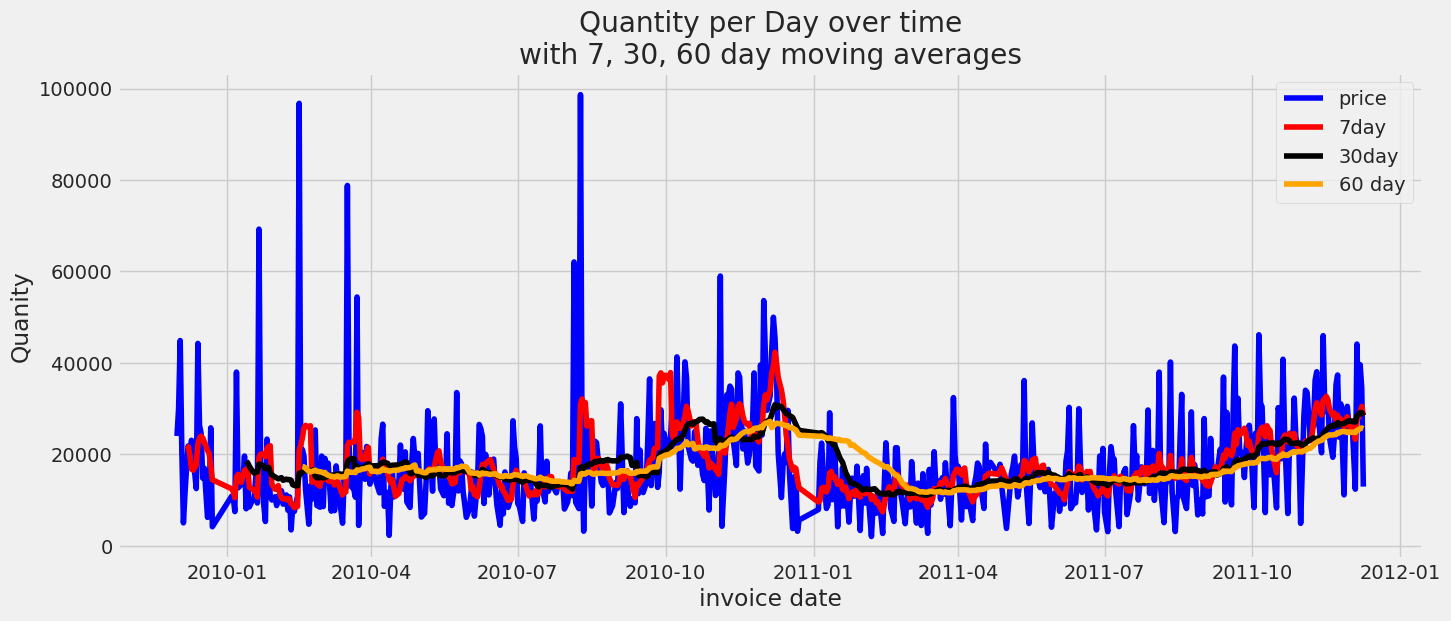

In [88]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="Quantity", color="blue", label="price")
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="7day_moving_avg_Quantity", color="red", label="7day")
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="30day_moving_avg_Quantity", color="black", label="30day")
sns.lineplot(data=df_grouped1, x="InvoiceDay", y="60day_moving_avg_Quantity", color="orange", label="60 day")

plt.title("Quantity per Day over time\nwith 7, 30, 60 day moving averages")
plt.xlabel("invoice date")
plt.ylabel("Quanity")
plt.show()

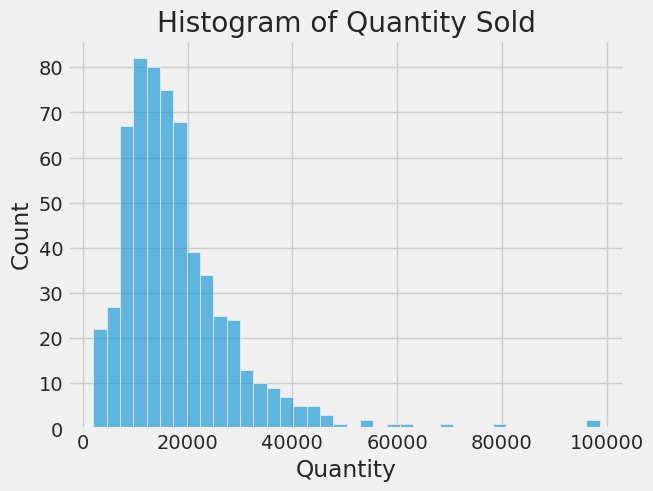

In [94]:
# lets look at a density plot of quantity per day
plt.figure()
sns.histplot(df_grouped1['Quantity'], fill=True, alpha=.6)
plt.title("Histogram of Quantity Sold")
plt.show()

### Modeling

Going to model **7day_moving_avg_Quantity** sold over time

In [204]:
# narrowing down to relevant fields
df_model = df_grouped1[["InvoiceDay", "7day_moving_avg_Quantity"]]
df_model = df_model.set_index("InvoiceDay")

data = df_model.filter(['7day_moving_avg_Quantity'])
data = data.values

train_size = .8
n_train = int(train_size * len(data))
print(f"records in training data: {n_train}")
print(f"records in test data: {len(data)-n_train}")

records in training data: 483
records in test data: 121


In [205]:
# scaling the data before we feed it into model
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [217]:
# creating the scaled training dataset
train_data = scaled_data[:n_train, :]

def create_train_data(train_data, lookback: int = 15):

    X_train = []
    y_train = []
    for i in range(lookback, n_train):
        X_train.append(train_data[i-lookback:i, 0])
        y_train.append(train_data[i, 0])

    # convert the x_train and y_train to numpy arrays 
    X_train, y_train = np.array(X_train), np.array(y_train)

    # reshape the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, y_train

X_train, y_train = create_train_data(train_data)

In [207]:
model = Sequential([
    LSTM(units=128, activation="tanh", input_shape=(X_train.shape[1], 1), return_sequences=True,),
    LSTM(units=64, activation="tanh", return_sequences=True),
    Dense(25),
    Dense(1, activation="relu"),
])

model.compile(optimizer="adam", loss="mean_squared_error")

batch_size = 1
epochs=1
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

468/468 [==============================] - 9s 11ms/step - loss: nan


In [219]:
def create_test_data(lookback: int = 15):
    test_data = scaled_data[n_train - lookback:, :]
    X_test = []
    y_test = data[n_train:, :]

    for i in range(lookback, len(test_data)):
        X_test.append(test_data[i-lookback:i, 0])

    # Convert the data to a numpy array
    X_test = np.array(X_test)

    # Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_test, y_test

X_test, y_test = create_test_data()

In [209]:
# making predictions with first simple model
preds = model.predict(X_test)

# reshaping
preds = preds.reshape(121,15)
preds = reshape1_preds[:, -1:]

preds = scaler.inverse_transform(preds)

4/4 [==============================] - 1s 11ms/step


In [210]:
# grabbing RMSE of predictions
rmse = np.sqrt(np.mean((preds-y_test)**2))
rmse

9710.323542793647

In [215]:
dataset = df_model.filter(['7day_moving_avg_Quantity'])
train = dataset[:n_train]
valid = dataset[n_train:]

valid['predictions'] = preds

def plot_preds(train_data, valid_data):
    
    plt.figure(figsize=(18,6))
    sns.lineplot(data=train_data, x="InvoiceDay", y="7day_moving_avg_Quantity", label="train")
    sns.lineplot(data=valid_data, x="InvoiceDay" ,y="predictions", label="preds")
    sns.lineplot(data=valid_data, x="InvoiceDay" ,y="7day_moving_avg_Quantity", label="validation",ls=":")

    plt.title("Training, Validation Data and Predictions")
    plt.show()

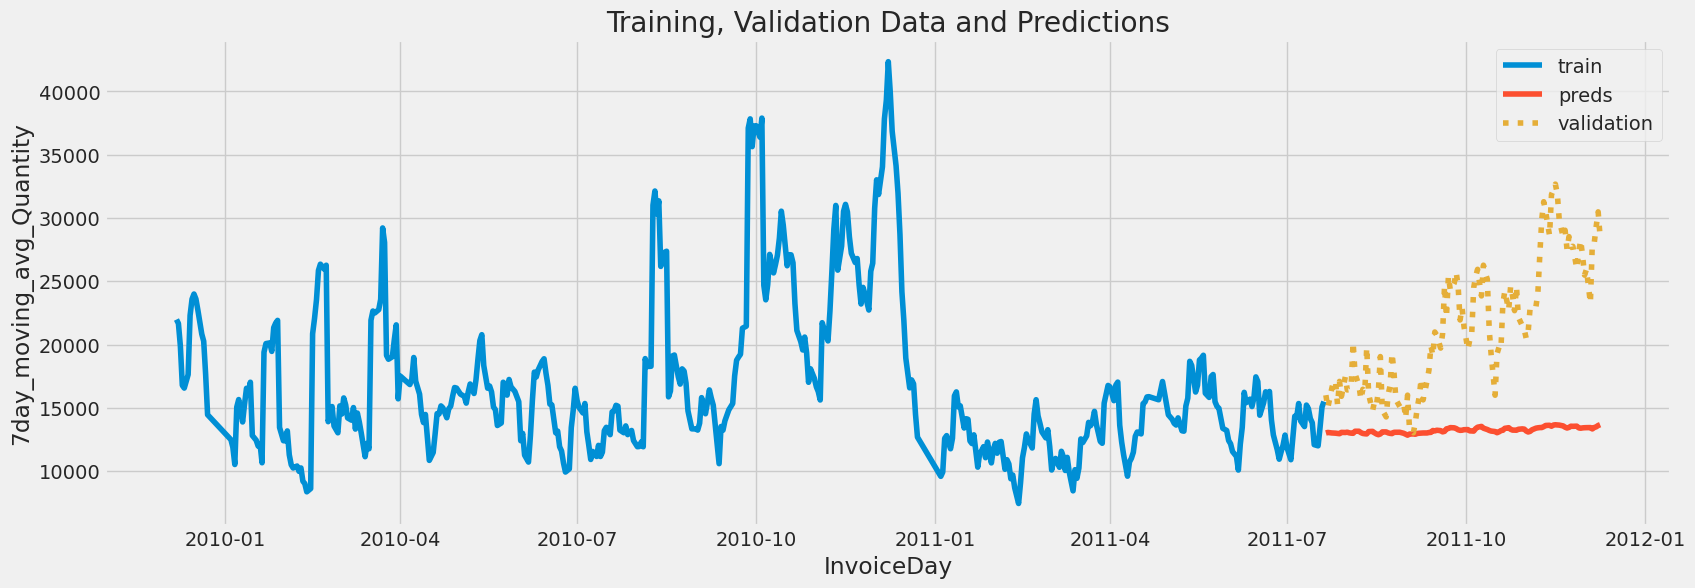

In [214]:
plot_preds(train, valid)

We can see from the above plot that the model did a rather poor job of predicting the future 7 day rolling window average of quantity sold. The model output fairly uniform predictions throughout the remainder of the time series. 

Am going to tweak the model and see if I can get any better performance

#### Updating Lookback period and model

In [220]:
X_train, y_train = create_train_data(train_data, lookback=45)
X_test, y_test = create_test_data(lookback=45)

In [228]:
model2 = Sequential([
    LSTM(units=128, activation="tanh", input_shape=(X_train.shape[1], 1), return_sequences=True,),
    LSTM(units=64, activation="tanh", return_sequences=True),
    Dropout(.3),
    Dense(25),
    BatchNormalization(),
    Dense(1),
])

model2.compile(optimizer="adam", loss="mean_squared_error")

batch_size = 1
epochs=1
model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

438/438 [==============================] - 15s 26ms/step - loss: nan


4/4 [==============================] - 1s 28ms/step


/tmp/ipykernel_32/2838328860.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = preds


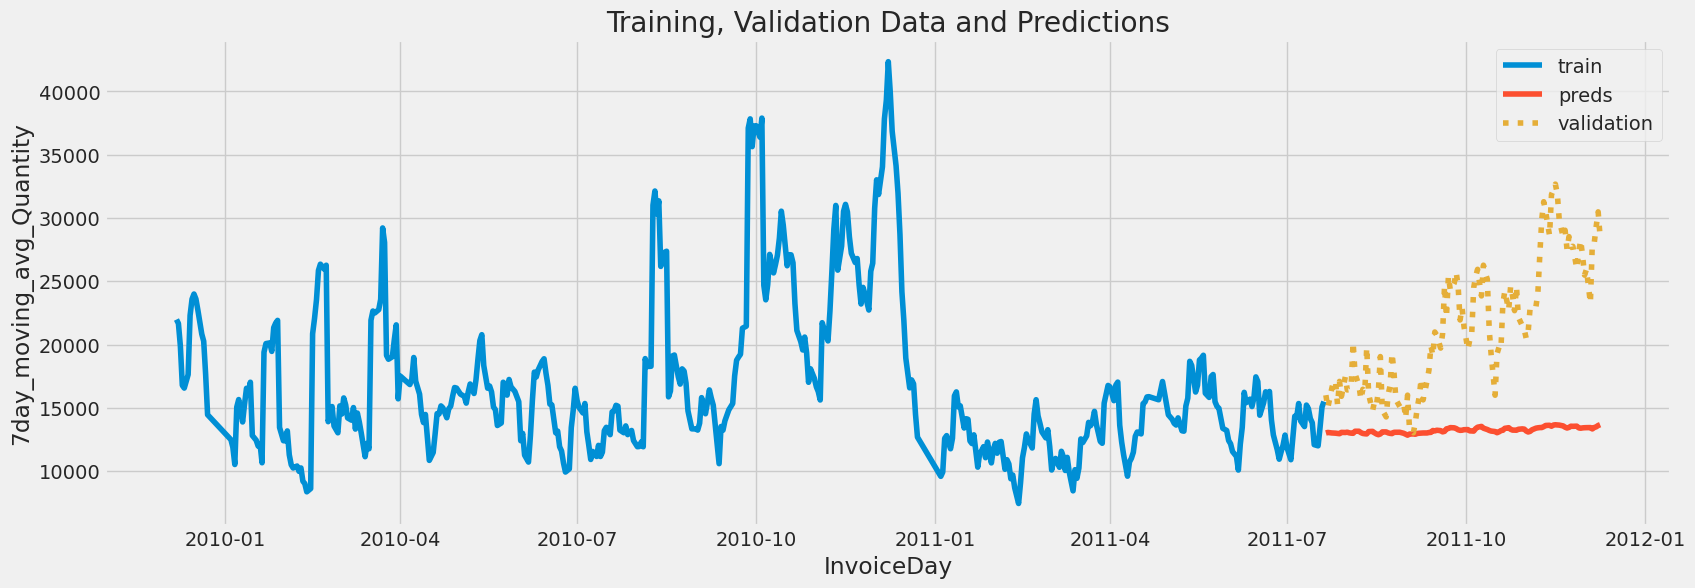

In [229]:
# making predictions with first simple model
preds = model2.predict(X_test)

# reshaping
preds = preds.reshape(121, 45)
preds = reshape1_preds[:, -1:]
preds = scaler.inverse_transform(preds)

dataset = df_model.filter(['7day_moving_avg_Quantity'])
train = dataset[:n_train]
valid = dataset[n_train:]

valid['predictions'] = preds

plot_preds(train, valid)

In [230]:
rmse = np.sqrt(np.mean((preds-y_test)**2))
rmse

9710.323542793647

### Conclusion

In this project I performed Exploratory Analysis on a dataset containing transaction details for a retailer over the course of two years. I showed how the time series data could be smoothed to account for moving averages over various windows. Finally I built two LSTM models to predict future quantities sold accounting for a different model architecture and different lookback period. 

Moving forward I would like to iterate on the model architecture to force the model to output more accurate, and realistic predictions. I can perform more time series smoothing on the data to get rid of noise and feed more signal into the final model.